
# Online Payments Fraud Detection — Starter Notebook

**Objetivo:** Detectar transacciones fraudulentas en pagos en línea y reducir el costo esperado manteniendo falsos positivos manejables. En otras palabras, reducir pérdidas por fraude sin frenar a clientes legítimos, identificando qué método concentra más casos y dónde reforzar primero.


## ¿Qué método de fraude concentra más casos para priorizar controles?

In [15]:

# === Configuración ===
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, confusion_matrix, classification_report
)
from sklearn.ensemble import HistGradientBoostingClassifier

RANDOM_STATE = 42
CSV_PATH = "onlinefraud.csv"  # Cambia esta ruta según tu archivo
print("Usando CSV en:", os.path.abspath(CSV_PATH))


Usando CSV en: c:\Users\fanyc\Documents\TripleTen\Job\New_projects\onlinefraud.csv


In [16]:

# === Carga de datos ===
df = pd.read_csv(CSV_PATH)
print("Forma:", df.shape)
display(df.head(3))
print("\nTipos de datos:")
print(df.dtypes.value_counts())


Forma: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0



Tipos de datos:
float64    5
int64      3
object     3
Name: count, dtype: int64


In [17]:

# === Selección de objetivo ===
candidate_targets = ["isFraud", "Class", "fraud", "target", "label"]
target_col = next((c for c in candidate_targets if c in df.columns), None)
if target_col is None:
    raise ValueError(f"No se encontró columna objetivo entre {candidate_targets}. Edita esta celda y pon el nombre correcto.")
print("Columna objetivo:", target_col)

if not np.issubdtype(df[target_col].dtype, np.integer):
    try:
        df[target_col] = df[target_col].astype(int)
    except Exception as e:
        print("Aviso: No se pudo convertir objetivo a int:", e)

print("\nDistribución de clases:")
print(df[target_col].value_counts().sort_index())
print("Proporción de fraude:", (df[target_col]==1).mean())

print("\nNulos por columna (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))


Columna objetivo: isFraud

Distribución de clases:
isFraud
0    6354407
1       8213
Name: count, dtype: int64
Proporción de fraude: 0.001290820448180152

Nulos por columna (top 20):


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [18]:

# === Features ===
y = df[target_col].values
likely_id_cols = [c for c in df.columns if c.lower() in {"nameorig","namedest","userid","user_id","id"}]
feature_cols = [c for c in df.columns if c != target_col and c not in likely_id_cols]
X = df[feature_cols].copy()

cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Numéricas:", len(num_cols), "| Categóricas:", len(cat_cols), "| IDs descartadas:", likely_id_cols)


Numéricas: 7 | Categóricas: 1 | IDs descartadas: ['nameOrig', 'nameDest']


In [19]:

# === Split estratificado ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Tamaño train/test:", X_train.shape, X_test.shape)


Tamaño train/test: (5090096, 8) (1272524, 8)


In [20]:

# === Preprocesamiento y baseline ===
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder="drop", verbose_feature_names_out=False
)

pipe_lr = Pipeline([("prep", preprocess), ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))])
pipe_lr.fit(X_train, y_train)
proba_lr = pipe_lr.predict_proba(X_test)[:, 1]
roc_auc_lr = roc_auc_score(y_test, proba_lr)
ap_lr = average_precision_score(y_test, proba_lr)
print(f"LogReg -> ROC-AUC: {roc_auc_lr:.4f} | AUC-PR: {ap_lr:.4f}")


LogReg -> ROC-AUC: 0.9947 | AUC-PR: 0.5931


In [21]:

# === Modelo principal: HistGradientBoosting ===
hgb = HistGradientBoostingClassifier(learning_rate=0.06, max_leaf_nodes=31, early_stopping=True, random_state=RANDOM_STATE)
pipe_hgb = Pipeline([("prep", preprocess), ("clf", hgb)])
pipe_hgb.fit(X_train, y_train)
proba_hgb = pipe_hgb.predict_proba(X_test)[:, 1]
roc_auc_hgb = roc_auc_score(y_test, proba_hgb)
ap_hgb = average_precision_score(y_test, proba_hgb)
print(f"HGB    -> ROC-AUC: {roc_auc_hgb:.4f} | AUC-PR: {ap_hgb:.4f}")


HGB    -> ROC-AUC: 0.9424 | AUC-PR: 0.8133


In [22]:
(df.groupby('type')
   .agg(total=('isFraud','size'),
        fraudes=('isFraud','sum'))
   .assign(tasa=lambda t: t['fraudes']/t['total'],
           pct_casos=lambda t: t['fraudes']/t['fraudes'].sum())
   .sort_values(['fraudes','tasa'], ascending=False))

,total,fraudes,tasa,pct_casos
type,,,,
CASH_OUT,2237500,4116,0.001840,0.501157
TRANSFER,532909,4097,0.007688,0.498843
CASH_IN,1399284,0,0.000000,0.000000
DEBIT,41432,0,0.000000,0.000000
PAYMENT,2151495,0,0.000000,0.000000


* Observaciones:

*CASH_OUT: 4,116 fraudes (50.12% del total).*

*TRANSFER: 4,097 fraudes (49.88%).*

El método con más casos es CASH_OUT, pero la diferencia es mínima (prácticamente 50/50).


*Riesgo por tasa de fraude (densidad de riesgo)*

TRANSFER: 0.7688% (≈ 4.2× más riesgoso por transacción que CASH_OUT).

CASH_OUT: 0.1840%.

In [23]:

# === Umbral por costo ===

def best_threshold_cost_fast(y_true, y_proba, cost_fp=1.0, cost_fn=15.0):
    order = np.argsort(-y_proba)              # scores descendentes
    y_sorted = y_true[order].astype(int)
    s_sorted = y_proba[order]

    tp = np.cumsum(y_sorted)                   # TP si corto en k
    fp = np.cumsum(1 - y_sorted)               # FP si corto en k
    P = y_sorted.sum()
    N = len(y_sorted) - P
    fn = P - tp
    tn = N - fp

    expected_cost = cost_fp * fp + cost_fn * fn
    k_star = int(np.argmin(expected_cost))     # índice óptimo
    thr_star = float(s_sorted[k_star])         # umbral equivalente

    precision = tp[k_star] / (tp[k_star] + fp[k_star]) if (tp[k_star] + fp[k_star]) else 0.0
    recall    = tp[k_star] / P if P else 0.0
    fpr       = fp[k_star] / N if N else 0.0

    return {
        "thr": thr_star,
        "precision": float(precision),
        "recall": float(recall),
        "fpr": float(fpr),
        "expected_cost": float(expected_cost[k_star]),
        "tp": int(tp[k_star]),
        "fp": int(fp[k_star]),
        "tn": int(tn[k_star]),
        "fn": int(fn[k_star]),
        "k_index": k_star
    }

best_lr  = best_threshold_cost_fast(y_test, proba_lr,  cost_fp=1.0, cost_fn=15.0)
best_hgb = best_threshold_cost_fast(y_test, proba_hgb, cost_fp=1.0, cost_fn=15.0)
print("Best (LR):", best_lr)
print("Best (HGB):", best_hgb)



Best (LR): {'thr': 0.9593579077666288, 'precision': 0.2760942760942761, 'recall': 0.6987218502738892, 'fpr': 0.0023684357544097364, 'expected_cost': 10435.0, 'tp': 1148, 'fp': 3010, 'tn': 1267871, 'fn': 495, 'k_index': 4157}
Best (HGB): {'thr': 0.008872841367387856, 'precision': 0.6812227074235808, 'recall': 0.8545343883140597, 'fpr': 0.0005169642161618593, 'expected_cost': 4242.0, 'tp': 1404, 'fp': 657, 'tn': 1270224, 'fn': 239, 'k_index': 2060}


In [24]:

# === Reporte compacto ===
from sklearn.metrics import classification_report

def report(model_name, proba, best):
    print(f"\n[{model_name}] thr={best['thr']:.4f} | expected_cost={best['expected_cost']:.1f}")
    y_pred_best = (proba >= best['thr']).astype(int)
    print(classification_report(y_test, y_pred_best, digits=3))

print("=== Métricas globales ===")
print(f"LogReg -> ROC-AUC: {roc_auc_lr:.4f} | AUC-PR: {ap_lr:.4f}")
print(f"HGB    -> ROC-AUC: {roc_auc_hgb:.4f} | AUC-PR: {ap_hgb:.4f}")
report("LogisticRegression", proba_lr, best_lr)
report("HistGradientBoosting", proba_hgb, best_hgb)

# Guardado
import joblib, pathlib
pathlib.Path('models').mkdir(exist_ok=True, parents=True)
joblib.dump(pipe_lr, 'models/online_fraud_logreg.joblib')
joblib.dump(pipe_hgb, 'models/online_fraud_hgb.joblib')
print("Modelos guardados en ./models/")


=== Métricas globales ===
LogReg -> ROC-AUC: 0.9947 | AUC-PR: 0.5931
HGB    -> ROC-AUC: 0.9424 | AUC-PR: 0.8133

[LogisticRegression] thr=0.9594 | expected_cost=10435.0
              precision    recall  f1-score   support

           0      1.000     0.998     0.999   1270881
           1      0.276     0.699     0.396      1643

    accuracy                          0.997   1272524
   macro avg      0.638     0.848     0.697   1272524
weighted avg      0.999     0.997     0.998   1272524


[HistGradientBoosting] thr=0.0089 | expected_cost=4242.0
              precision    recall  f1-score   support

           0      1.000     0.999     1.000   1270881
           1      0.675     0.855     0.754      1643

    accuracy                          0.999   1272524
   macro avg      0.838     0.927     0.877   1272524
weighted avg      0.999     0.999     0.999   1272524

Modelos guardados en ./models/


In [25]:

# === Recall@k ===
def recall_at_k(y_true, y_proba, k=0.005):
    n = len(y_true)
    top = max(1, int(n * k))
    idx = np.argsort(-y_proba)[:top]
    return float(y_true[idx].sum() / y_true.sum()) if y_true.sum() else 0.0

for k in [0.001, 0.005, 0.01]:
    print(f"Recall@{k*100:.1f}%  LR:", recall_at_k(y_test, proba_lr, k), "| HGB:", recall_at_k(y_test, proba_hgb, k))


Recall@0.1%  LR: 0.5009129640900791 | HGB: 0.7267194157029824
Recall@0.5%  LR: 0.7632379793061473 | HGB: 0.8910529519172246
Recall@1.0%  LR: 0.8508825319537432 | HGB: 0.9087035909920876


En el canal on-line, el fraude se concentra en CASH_OUT (50.1%) y TRANSFER (49.9%). Sin embargo, por tasa, TRANSFER (0.7688%) es ≈4.2× más riesgoso que CASH_OUT (0.1840%). Con el modelo HGB (AUC-PR=0.8133) y un umbral óptimo por costo (thr≈0.0089), capturamos ~85.5% del fraude con FPR≈0.00052; además, revisando el top 0.5–1% de scores se captura ~89–91% de casos.

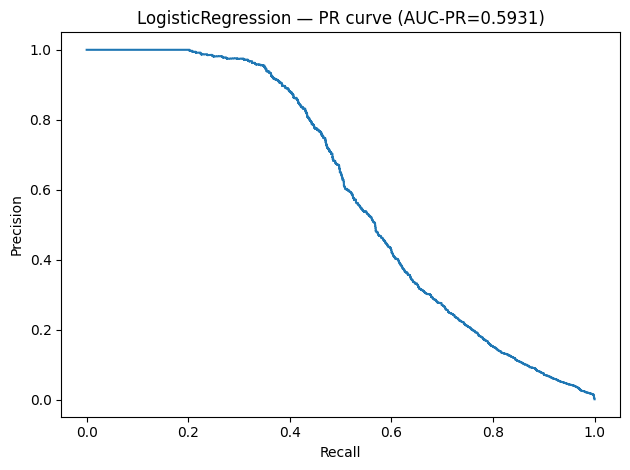

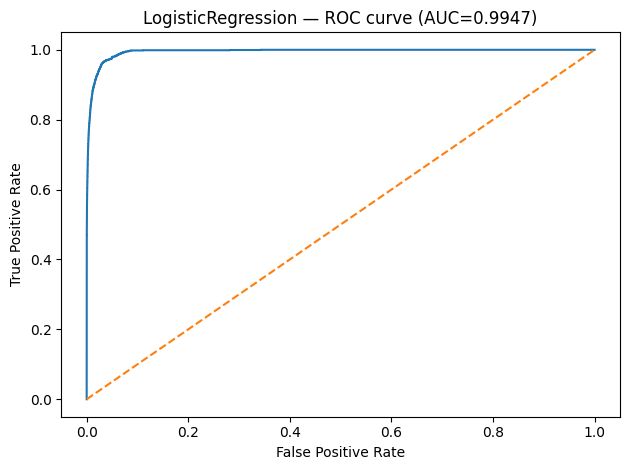

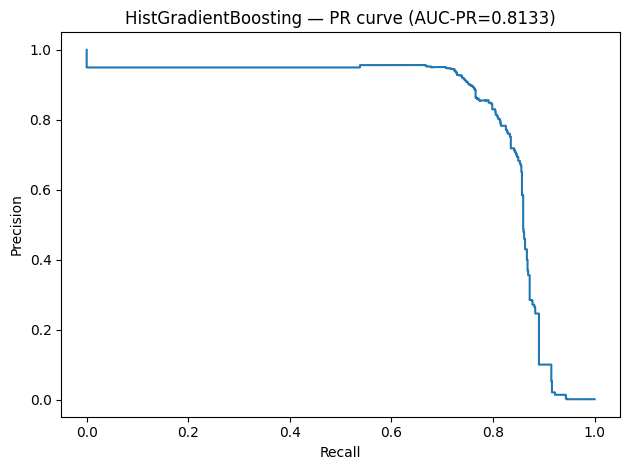

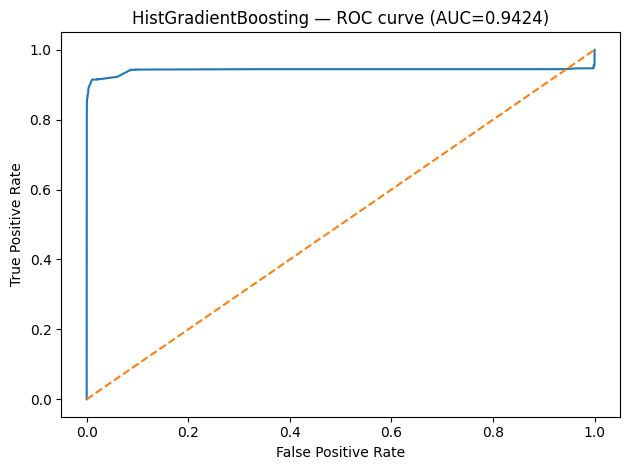

In [26]:

# === Curvas PR y ROC ===
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

def plot_pr(y_true, y_proba, title):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.figure()
    plt.step(recall, precision, where="post")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{title} — PR curve (AUC-PR={ap:.4f})")
    plt.tight_layout(); plt.show()

def plot_roc(y_true, y_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr); plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"{title} — ROC curve (AUC={roc_auc:.4f})")
    plt.tight_layout(); plt.show()

plot_pr(y_test, proba_lr, "LogisticRegression")
plot_roc(y_test, proba_lr, "LogisticRegression")
plot_pr(y_test, proba_hgb, "HistGradientBoosting")
plot_roc(y_test, proba_hgb, "HistGradientBoosting")



# Informe

**Metodología:** Split estratificado, baseline con LR balanceada, HGB como modelo principal, **AUC-PR** y ROC-AUC, **umbral por costo**, Recall@k.

**Resultados:** AUC-PR 0.8133 (en fraude ultra desbalanceado).

Con umbral óptimo: Recall ~85.5% y FPR ~0.052%.

Top-K: revisando 0.5–1% de operaciones más sospechosas se captura ~89–91% del fraude.

**Recomendaciones**
- **TRANSFER (prioridad por tasa):** step-up 2FA, device binding, velocity checks, límites dinámicos y listas de riesgo del destinatario.  
- **CASH_OUT (prioridad por volumen):** OTP/2FA, revisión top-K, reglas de monto/horario y retención si proviene de una transferencia reciente.


> Impacto esperado: menos pérdidas y menos fricción para clientes legítimos, enfocando los controles donde realmente ocurren los intentos de fraude.
